In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox

In [3]:
print(pd.__version__)
print(gpd.__version__)
print(ox.__version__)

0.19.1
0.2.1
0.1a1


Read in user data

In [4]:
users = pd.read_csv(r'userdata-synthetic-01.csv')
# dump untitled columns
users = users.drop([c for c in users.columns if c.startswith('Unnamed')], 1)  # 1 == columns
users.head()

,firstName,lastName,homeAddress,workAddress,arrivalTime
0,Prince,Lee,"31 W Coast Park, Singapore 127649","8 Shenton Way, AXA Tower",7.30am
1,Eric,Dugan,"41 Faber Walk, Singapore 128971","Raffles City, 252 North Bridge Road, 179103",8am
2,Edward,Roberts,"43 Faber Walk, Singapore 128972","Interntional Plaza, 10 Anson Rd, Singapore 079903",8.30am
3,Donna,Harden,"74 Faber Heights, Singapore 129194","Keppel Towers, 10 Hoe Chiang Rd, Singapore 089315",9am
4,Anne,Garcia,"50C Faber Heights, Singapore 129197","8 Shenton Way, AXA Tower",9.30am


## Geocoding

Code to handle geocoding, with caching to avoid calling the API too often.

In [5]:
from geopy.exc import GeocoderQuotaExceeded

class Geocode():
    # TODO: filename should be mandatory. If file does not exist, just save variable.
    def __init__(self, filename=None):
        self.cache_filename = filename
        if filename:
            self.cache = gpd.read_file(filename).set_index('address')
        else:
            # empty cache
            self.cache = gpd.GeoDataFrame(pd.DataFrame({'address': []}).set_index('address'),
                                          geometry=[])
            self.cache.index.name = 'address'

    def save(self, filename=None):
        if not filename:
            filename = self.cache_filename

        if filename:
            # index is reset to work around geopandas not saving index
            self.cache.reset_index().to_file(filename)
        else:
            raise Exception('No cache file name specified.')

    @staticmethod
    # Note that the address returned after geocoding is the normalised address,
    # _not_ the given address. Hence we need to replace the normalised address
    # with the original address.
    def get_geocode(addrs, **kwargs):
        addrs = pd.Series(addrs)
        print('Geocoding ' + str(addrs.size) + ' addresses...')
        geoloc = gpd.tools.geocoding.geocode(addrs, **kwargs)
        # Override returned normalised addresses with raw input addresses
        geoloc['address'] = addrs
        geoloc.set_index('address', inplace=True)
        return geoloc

    def to_cache(self, geoloc):
        if self.cache.empty:
            self.cache = geoloc
        else:
            if self.cache.crs and geoloc.crs:
                geoloc = geoloc.to_crs(self.cache.crs)
            else:
                print('Warning: no coordinate reference system.')
            self.cache = self.cache.append(geoloc)

    def _dedup_batch_geocode_and_cache(self, addrs, batch_size=5, **kwargs):
        """Geocodes a list of addresses, appending result to cache."""
        addrs = pd.Index(addrs).drop_duplicates()
        addrs = addrs.difference(self.cache.index)
        if addrs.size > 0:
            for addr in np.array_split(addrs, -(-addrs.size // batch_size)):  # ceiling division
                geoloc = self.get_geocode(addr, **kwargs)
                self.to_cache(geoloc)

    def _match_address(self, pdf, colname):
        """Matches addresses, returning a copy."""
        # Note that the geodataframe is on the left. This allows pdf to be a
        # normal dataframe.
        pdf = self.cache.merge(pdf, how='right', left_index=True, right_on=colname)
        new_colname = colname + '_geo'
        if new_colname in pdf.columns:
            print('Warning: dropping existing ' + new_colname + ' column')
            pdf.drop(new_colname, axis=1, inplace=True)
        pdf = pdf.rename(columns={'geometry': new_colname}).set_geometry(new_colname)
        return pdf

    def geocode_col(self, pdf, colname, **kwargs):
        """Geocodes address.

        Append a new column containing the geocoded address, where the address
        is given in `colname`.
        """
        try:
            self._dedup_batch_geocode_and_cache(pdf[colname], **kwargs)
        except GeocoderQuotaExceeded:
            return self._match_address(pdf, colname)
            raise
        else:
            return self._match_address(pdf, colname)


Load address cache

In [6]:
gc = Geocode(r'address.cache')

Geocode the home and work address columns. This adds two new columns which stores the home and work geospatial object.

In [7]:
users_home = gc.geocode_col(users[['homeAddress']], 'homeAddress')
users_work = gc.geocode_col(users[['workAddress']], 'workAddress')
gc.save()
users_home.head()

,homeAddress_geo,homeAddress
0,POINT (103.753387 1.318911),"31 W Coast Park, Singapore 127649"
1,POINT (103.755132 1.3219479),"41 Faber Walk, Singapore 128971"
2,POINT (103.755 1.321933),"43 Faber Walk, Singapore 128972"
3,POINT (103.7554762 1.3236475),"74 Faber Heights, Singapore 129194"
4,POINT (103.755732 1.324143),"50C Faber Heights, Singapore 129197"


## Plot user locations on a basemap

Get outline of Singapore

In [8]:
# 3rd result gives island polygon. See https://nominatim.openstreetmap.org
city = ox.gdf_from_place('Singapore', which_result=3)

Project to UTM coordinates (automatically choosing region).

In [9]:
city = ox.project_gdf(city)
print(city.crs)

{'proj': 'utm', 'ellps': 'GRS80', 'zone': 48, 'datum': 'NAD83', 'units': 'm'}


Project the geometry of the user addresses to match that of the base map

In [10]:
users_home = users_home.to_crs(city.crs)
users_work = users_work.to_crs(city.crs)

Now that we are using the same coordinate system for the basemap, home and work addresses, we can plot them.

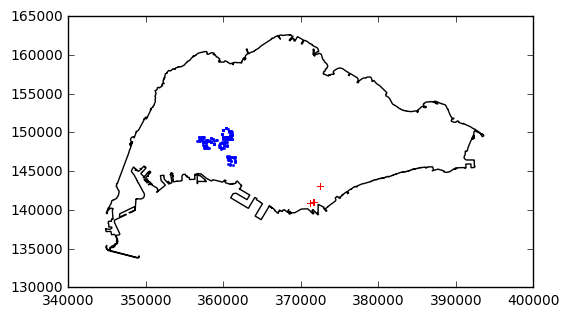

In [11]:
fig, ax = plt.subplots();
ax.set_aspect('equal');
city.plot(ax=ax, color='white');
users_home.plot(ax=ax, marker='.', color='blue', markersize=3);
users_work.plot(ax=ax, marker='+', color='red', markersize=5);

## Plot on road map

Get a bounding box of the user home addresses, with a 500 meter buffer.

In [12]:
home_box = (users_home.to_crs('+init=epsg:3395')   # Project to crs that uses meters as distance measure
            .buffer(500)                           # 500m buffer
            .to_crs('+init=epsg:4326')             # Polygon needs to be in this coords
            .unary_union.envelope
           )
print(home_box)

POLYGON ((103.7064012235794 1.314390362462093, 103.7602235764206 1.314390362462093, 103.7602235764206 1.366583548308357, 103.7064012235794 1.366583548308357, 103.7064012235794 1.314390362462093))


Now that we have a bounding box, we can download all roads in that bounding box from OpenStreetMaps.

In [13]:
G = ox.graph_from_polygon(home_box, network_type='drive')
G = ox.project_graph(G)  # Project coordinates to UTM.

Check that the NetworkX graph has the same coordinate system as the home locations, then plot.

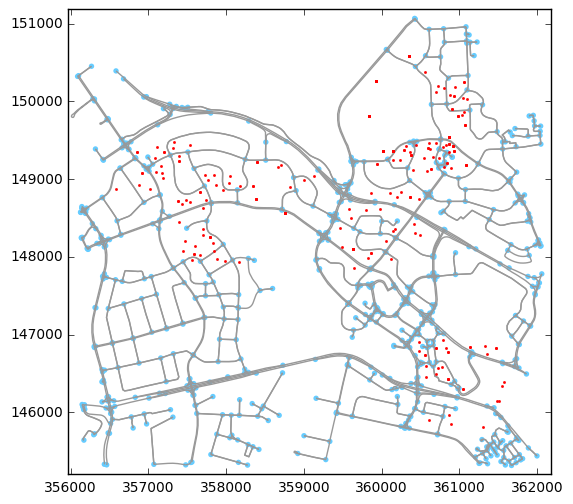

In [14]:
if users_home.crs == G.graph['crs']:
    fig, ax = ox.plot_graph(G, axis_off=False, show=False, close=False);
    ax.set_aspect('equal');
    users_home.plot(ax=ax, marker='.', color='red', markersize=3);